In [1]:
import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import sounddevice as sd
import IPython.display as ipd
import pandas as pd
from librosa import effects
import scipy.signal as sp
import statistics as st


In [2]:
def get_audio_split(y,sr):
    duration_ogn = len(y)/sr
    if(duration_ogn <= 30.0):
      data = 15 * sr
    elif(duration_ogn <= 15.0):
      data = 10 * sr 
    elif(duration_ogn <= 10.0):
      data = 5 * sr
    elif(duration_ogn > 30.0):
        data = 30 * sr
    else:
      data = y   

    return data  


In [3]:
def get_n_fft_val(y,sr):
  duration = len(y)/sr

  if(duration < 2.0):
    n_fft_val =512
  else:
    n_fft_val = 1024   

  return n_fft_val

In [8]:
def reduce_audio_noise(y,sr,n_fft_val):

    n_fft_val = get_n_fft_val(y,sr)

    reduced_noise = nr.reduce_noise(y=y,sr=sr,stationary=False,prop_decrease=0.8,n_fft=n_fft_val,freq_mask_smooth_hz=300, time_mask_smooth_ms=50)  

    return reduced_noise

In [9]:
def get_compress(reduced_noise):
  
  y_comp = librosa.effects.preemphasis(reduced_noise, coef=0.97)

  return y_comp


In [10]:
def print_wave(y):
  
  librosa.display.waveshow(y)


In [11]:
def get_s(y):
    S,phase = librosa.magphase(librosa.stft(y))
    return S

In [12]:
def get_spect_db(y):
  audio_stft = librosa.stft(y)
  spect_db = librosa.amplitude_to_db(np.abs(audio_stft), ref=np.max)

  return spect_db

In [13]:
def get_mel_spect_db(y,sr):
  mel_spect = librosa.feature.melspectrogram(y=y,sr=sr)
  mel_spect_db = librosa.power_to_db(mel_spect,ref=np.max)

  return mel_spect_db

In [14]:
def print_spect_db(spect_db):
  fig, ax = plt.subplots(figsize=(10, 5))
  stft_dis = librosa.display.specshow(spect_db,x_axis='time',y_axis='log',ax=ax)
  ax.set_title('Spectogram', fontsize=20)
  fig.colorbar(stft_dis, ax=ax, format=f'%0.2f')
  plt.show()

In [15]:
def print_mel_spect_db(mel_spect_db,sr):
  plt.figure(figsize=(10,4))
  librosa.display.specshow(mel_spect_db, x_axis='time', y_axis='mel',sr=sr,cmap='magma')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.show()  

In [16]:
def get_rms(y):
    rms = librosa.feature.rms(S=get_s(y))
    return rms

In [17]:
def get_avg_rms(y):
    rms = get_rms(y)
    avg = np.mean(rms)
    return avg


In [18]:
def print_rms(rms,y):
  fig, ax = plt.subplots(nrows=2, sharex=True)
  times = librosa.times_like(rms)
  ax[0].semilogy(times, rms[0], label='RMS Energy')
  ax[0].set(xticks=[])
  ax[0].legend()
  ax[0].label_outer()
  librosa.display.specshow(librosa.amplitude_to_db(S=get_s(y), ref=np.max),y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='log Power spectrogram')
  S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
  librosa.feature.rms(S=S)
  plt.show()

In [19]:
def print_chroma(C,chroma):
  fig, ax = plt.subplots(nrows=2, sharex=True)
  img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),y_axis='log', x_axis='time', ax=ax[0])
  fig.colorbar(img, ax=[ax[0]])
  ax[0].label_outer()
  img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
  fig.colorbar(img, ax=[ax[1]])  


In [20]:
def get_avg_pitch(chroma):
  avg = np.mean(chroma)
  dominant_pitch = np.argmax(avg)
  note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
  avg_pitch = note_names[dominant_pitch]
  return avg_pitch

In [21]:
def get_chroma_freq(chroma):
  avg = np.mean(chroma)
  dominant_pitch = np.argmax(avg)
  midi_note = 60 + dominant_pitch
  frequency = librosa.midi_to_hz(midi_note)
  return frequency


In [22]:
def get_snip(y,sr):
  data = get_audio_split(y,sr)
  y = y[:data]
  return y

In [23]:
def get_freq(y,sr):
  f0 = librosa.yin(y, fmin=50, fmax=10000,sr=sr)
  avg_fun_freq = np.mean(f0)
  return avg_fun_freq

In [24]:
def print_freq(y,sr):
    f0 = librosa.yin(y, fmin=50, fmax=10000,sr=sr)
    plt.plot(f0)

In [25]:
def get_spect_cent(y):
  spect_cent = librosa.feature.spectral_centroid(S=get_s(y))
  return np.mean(spect_cent)

In [26]:
def get_snr(y_clean,y):
    
    signal_power = np.mean(y_clean ** 2)
    noise_power = np.mean(y ** 2)
    
    if noise_power == 0:
        return float('inf')
    
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [27]:
def get_harmonic(y):
    harmonic = librosa.effects.harmonic(y)
    return harmonic

In [28]:
def get_hnr_high(y, sr):
    f0 = librosa.yin(y, fmin=50, fmax=10000, sr=sr) 
    harmonic = librosa.effects.harmonic(y, margin=8)
    noise = y - harmonic                              
    hnr_high = 10 * np.log10(np.var(harmonic) / np.var(noise))
    return hnr_high

In [29]:
def get_hnr_low(y, sr):
    f0 = librosa.yin(y, fmin=50, fmax=10000, sr=sr) 
    harmonic = librosa.effects.harmonic(y, margin=1)
    noise = y - harmonic                              
    hnr_high = 10 * np.log10(np.var(harmonic) / np.var(noise))
    return hnr_high

In [30]:
def print_high_hnr(y,sr):
    harmonic = librosa.effects.harmonic(y, margin=8)
    S_harmonic = librosa.stft(harmonic)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_harmonic), ref=np.max), y_axis='log',sr=sr)
    plt.colorbar()
    plt.title("Harmonic Component")
    plt.plot()

In [31]:
def print_low_hnr(y,sr):
    harmonic = librosa.effects.harmonic(y, margin=1)
    S_harmonic = librosa.stft(harmonic)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_harmonic), ref=np.max), y_axis='log',sr=sr)
    plt.colorbar()
    plt.title("Harmonic Component")
    plt.plot()

In [32]:
def get_tonnetz(y,sr):
    tonnetz = librosa.feature.tonnetz(y=get_harmonic(y), sr=sr)
    return np.mean(tonnetz)

In [33]:
def get_mfcc(y,sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return np.mean(mfcc)

In [34]:
def get_roll_off(y,sr):
    roll_off = librosa.feature.spectral_rolloff(S=get_s(y), sr=sr)
    return np.mean(roll_off)

In [35]:
def get_flatness(y):
    flatness = librosa.feature.spectral_flatness(S=get_s(y))
    return np.mean(flatness)

In [36]:
def get_contrast(y,sr):
    contrast = librosa.feature.spectral_contrast(S=get_s(y), sr=sr)
    return np.mean(contrast)

In [37]:
y, sr = librosa.load('iNat888729.ogg')

In [38]:
#y = get_snip(y,sr) #only for CSA type files

# Before Cleaning

In [39]:
ipd.Audio(y,rate=sr,autoplay=False)

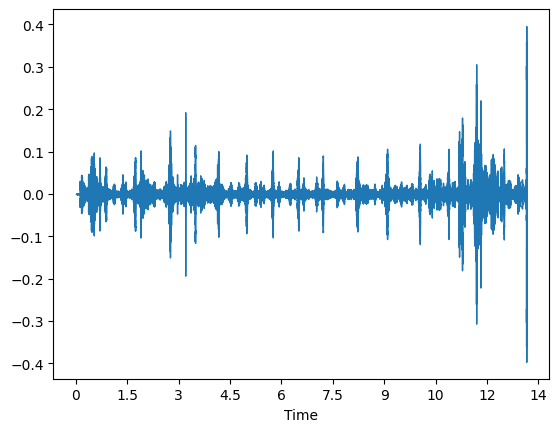

In [40]:
print_wave(y)

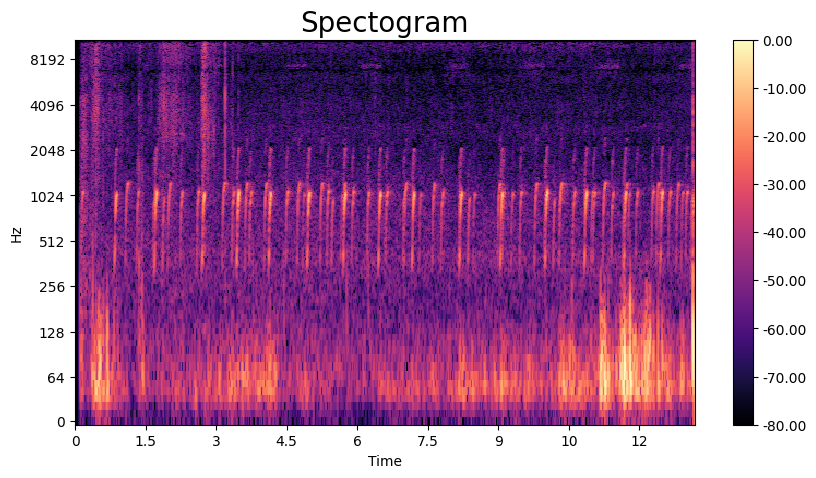

In [41]:
spect_before = get_spect_db(y)
print_spect_db(spect_before)

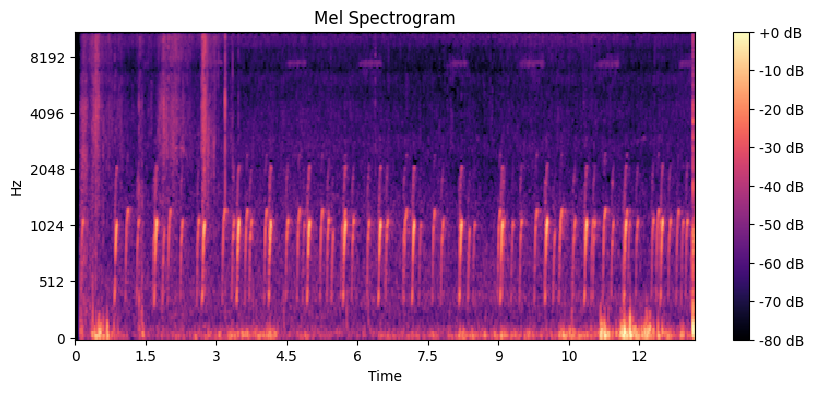

In [42]:
mel_spect_before = get_mel_spect_db(y,sr)
print_mel_spect_db(mel_spect_before,sr)

In [43]:
rms = get_rms(y)
print("Average RMS before processing: ", get_avg_rms(y))

Average RMS before processing:  0.007728795


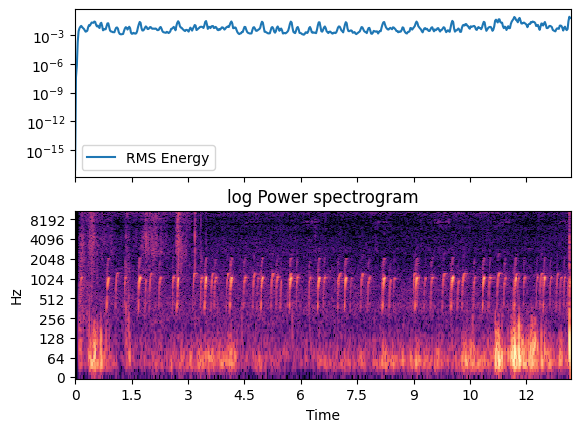

In [44]:
print_rms(rms,y)

In [45]:
C = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=C, sr=sr)
print("Average Pitch Before Cleaning:", get_freq(y,sr))
print("Average Spectral Centroid: ", get_spect_cent(y))

Average Pitch Before Cleaning: 799.1694391165111
Average Spectral Centroid:  2835.0228847227722


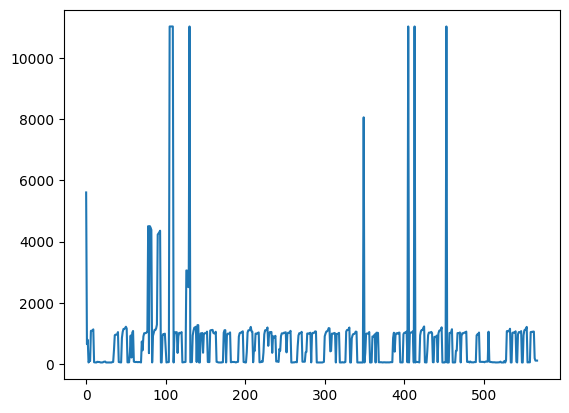

In [46]:
print_freq(y,sr)

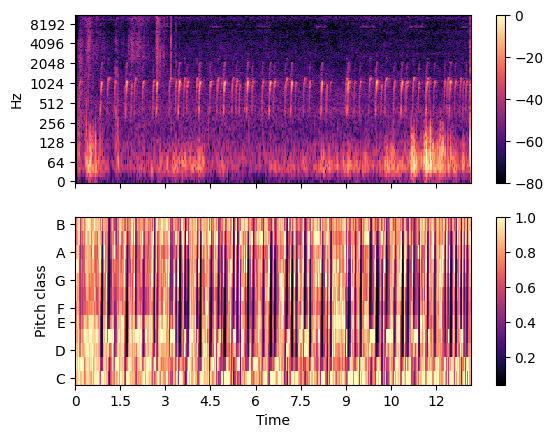

In [47]:
print_chroma(C,chroma)

# Cleaning

In [48]:
n_fft = get_n_fft_val(y,sr)
reduced_noise = reduce_audio_noise(y,sr,n_fft)
print(n_fft)

1024


In [49]:
y_reduced = reduced_noise

# Noise Reduction

In [50]:
ipd.Audio(y_reduced,rate=sr,autoplay=False)

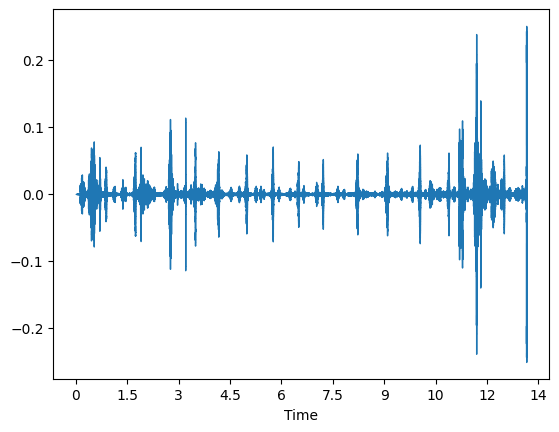

In [51]:
print_wave(y_reduced)

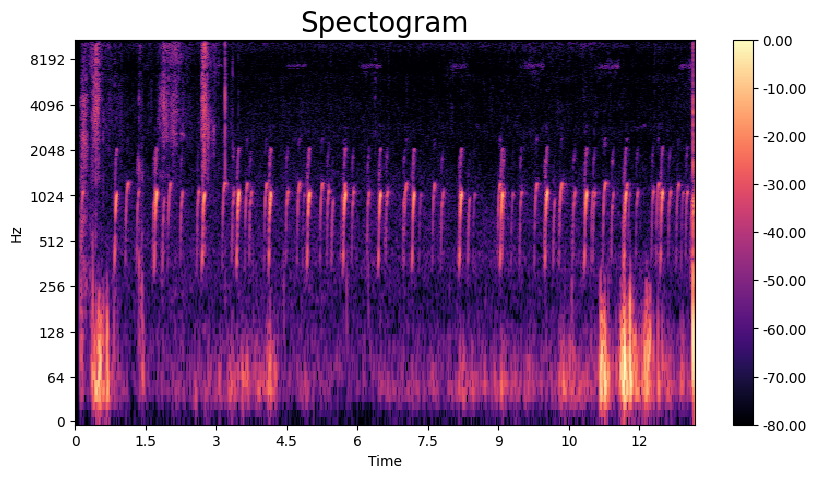

In [52]:
spect_after = get_spect_db(y_reduced)
print_spect_db(spect_after)

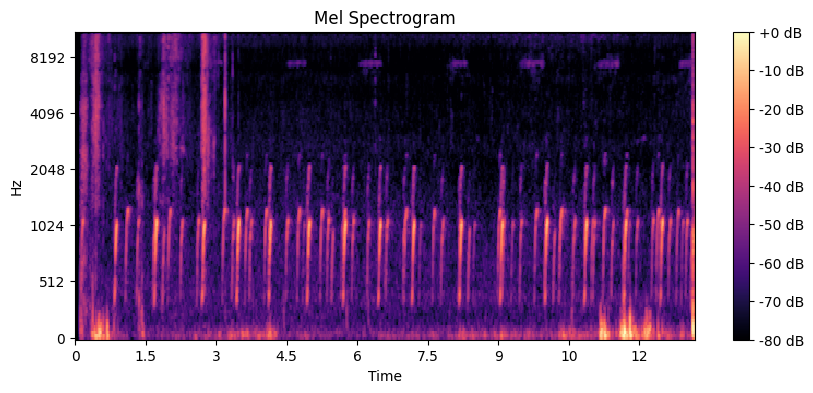

In [53]:
mel_spect_after = get_mel_spect_db(y_reduced,sr)
print_mel_spect_db(mel_spect_after,sr)

In [54]:
rms_reduced = get_rms(y_reduced)
print("Average RMS after Noise Reduction: ", get_avg_rms(y_reduced))

Average RMS after Noise Reduction:  0.0036976328


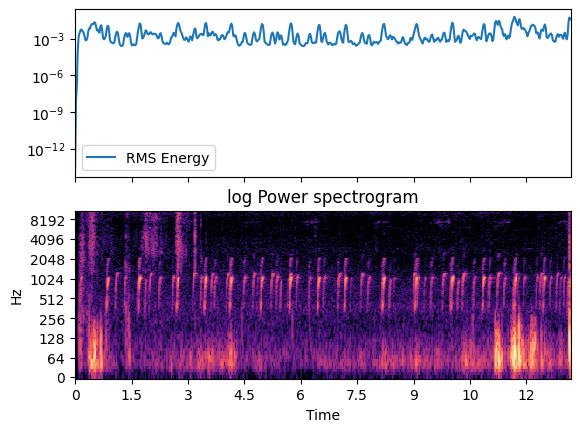

In [55]:
print_rms(rms_reduced,y_reduced)

In [56]:
C_reduced = np.abs(librosa.stft(y_reduced))
chroma_reduced = librosa.feature.chroma_stft(S=C_reduced, sr=sr)
print("Average Pitch After Noise Reduction: ", get_freq(y_reduced,sr))
print("Average Spectral Centroid: ", get_spect_cent(y_reduced))

Average Pitch After Noise Reduction:  1294.7214220939852
Average Spectral Centroid:  2721.7267835776615


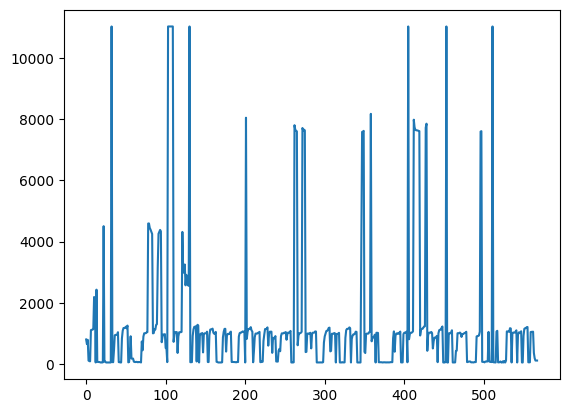

In [57]:
print_freq(y_reduced,sr)

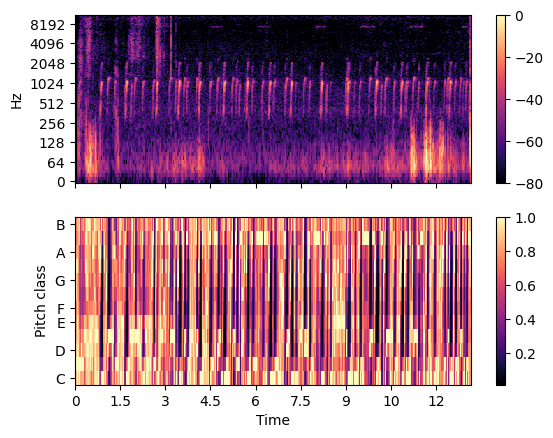

In [58]:
print_chroma(C_reduced,chroma_reduced)

# Compression

In [59]:
y_compressed = get_compress(reduced_noise)

In [60]:
ipd.Audio(y_compressed,rate=sr,autoplay=False)

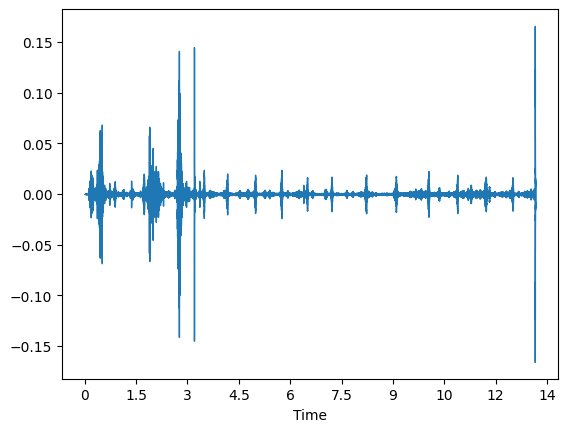

In [61]:
print_wave(y_compressed)

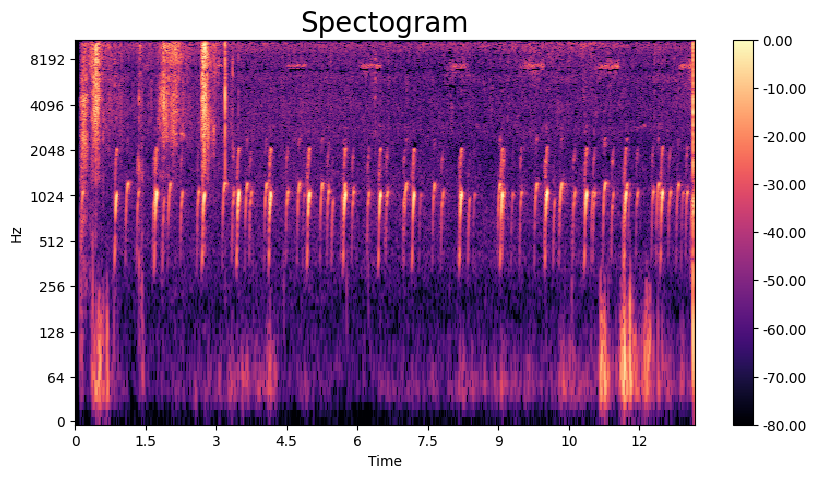

In [62]:
spect_comp = get_spect_db(y_compressed)
print_spect_db(spect_comp)

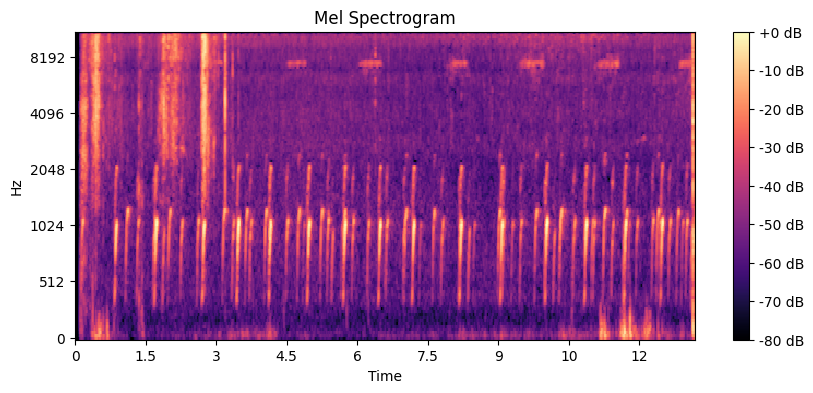

In [63]:
mel_spect_comp = get_mel_spect_db(y_compressed,sr)
print_mel_spect_db(mel_spect_comp,sr)

In [64]:
S_compressed, phase = librosa.magphase(librosa.stft(y_compressed ))
rms_compressed = librosa.feature.rms(S=S_compressed)
print("Average RMS after Compressing: ", get_avg_rms(rms_compressed))

Average RMS after Compressing:  0.0009221278


C:\Users\me2\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=568
  warnings.warn(


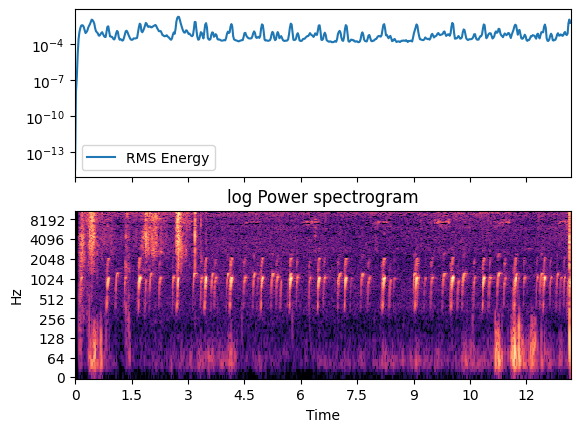

In [65]:
print_rms(rms_compressed,y_compressed)

In [66]:
C_comp = np.abs(librosa.stft(y_compressed))
chroma_comp = librosa.feature.chroma_stft(S=C_comp, sr=sr)
print("Average frequency after Compression: ", get_freq(y_compressed,sr))
print("Average Spectral Centroid: ", get_spect_cent(y_compressed))

Average frequency after Compression:  4592.486473759443
Average Spectral Centroid:  5514.500470429824


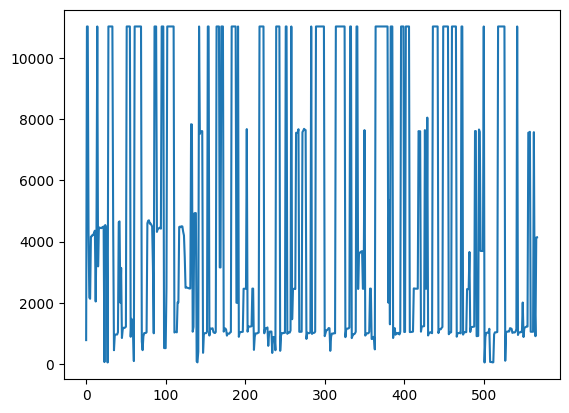

In [67]:
print_freq(y_compressed,sr)

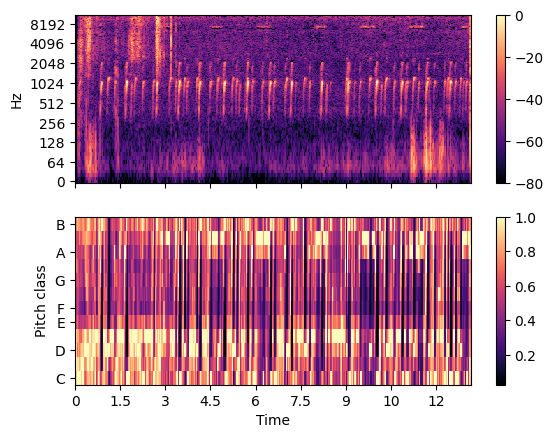

In [68]:
print_chroma(C_comp,chroma_comp)

In [69]:
snr = get_snr(y_reduced,y)
print("SNR Noise Reduced: ", snr)

SNR Noise Reduced:  -4.290171


In [70]:
snr_comp = get_snr(y_compressed,y)
print("SNR Compressed: ", snr_comp)

SNR Compressed:  -15.170341


In [71]:
reduced_high_hnr = get_hnr_high(y_reduced,sr)
print(reduced_high_hnr)

-26.436508


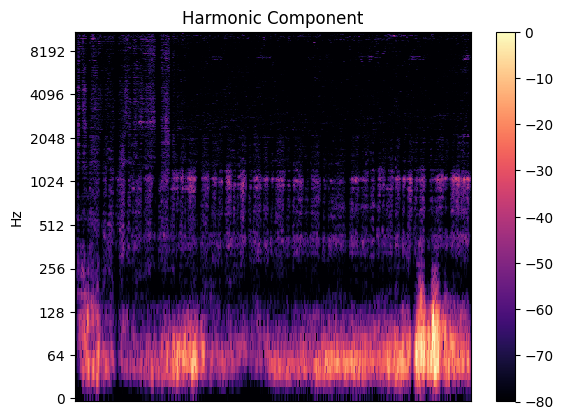

In [72]:
print_high_hnr(y_reduced,sr)

In [73]:
reduced_low_hnr = get_hnr_low(y_reduced,sr)
print(reduced_low_hnr)

-10.771184


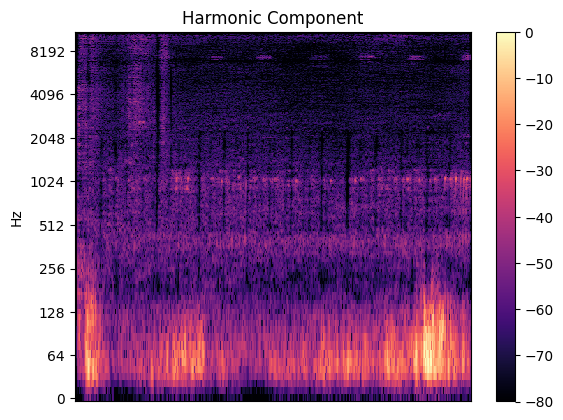

In [74]:
print_low_hnr(y_reduced,sr)

In [75]:
compressed_high_hnr = get_hnr_high(y_compressed,sr)
print(compressed_high_hnr)

-42.437836


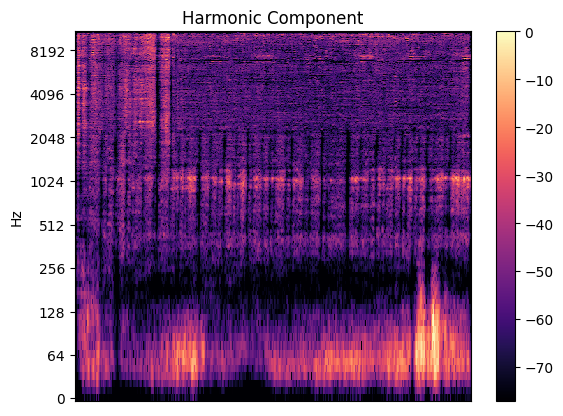

In [76]:
print_high_hnr(y_compressed,sr)

In [77]:
compressed_low_hnr = get_hnr_low(y_compressed,sr)
print(compressed_low_hnr)

-20.271292


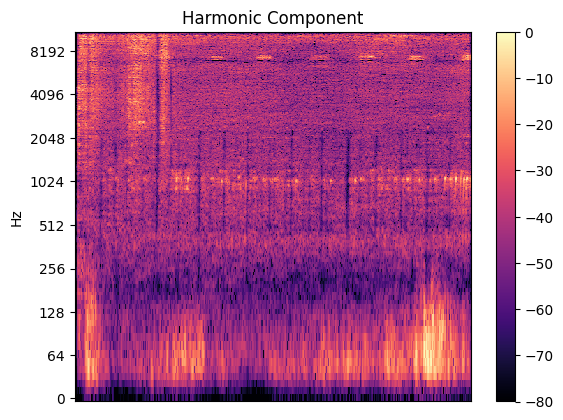

In [78]:
print_low_hnr(y_compressed,sr)

In [79]:
tone_b = get_tonnetz(y,sr)
print(tone_b)

-0.0009562532122477793


In [80]:
tonnetz_reduced = get_tonnetz(y_reduced,sr)
print(tonnetz_reduced)

-0.0015736354328723078


In [81]:
tonnetz_compressed = get_tonnetz(y_compressed,sr)
print(tonnetz_compressed)

0.005051576459953983


In [82]:
mfcc_b = get_mfcc(y,sr)
print(mfcc_b)

-8.887859


In [83]:
mfcc_reduced = get_mfcc(y_reduced,sr)
print(mfcc_reduced)

-15.872634


In [84]:
mfcc_compressed = get_mfcc(y_compressed,sr)
print(mfcc_compressed)

-28.821234


In [85]:
ro_b = get_roll_off(y,sr)
print(ro_b)

6456.530031016176


In [86]:
ro_red = get_roll_off(y_reduced,sr)
print(ro_red)

5825.489656690141


In [87]:
ro_comp = get_roll_off(y_compressed,sr)
print(ro_comp)

9181.31425884408


In [88]:
flat_b = get_flatness(y)
print(flat_b)

0.051502842


In [89]:
flat_red = get_flatness(y_reduced)
print(flat_red)

0.044523332


In [90]:
flat_comp = get_flatness(y_compressed)
print(flat_comp)

0.123455666


In [91]:
contrast_b = get_contrast(y,sr)
print(contrast_b)

18.976251489237416


In [92]:
contrast_red = get_contrast(y_reduced,sr)
print(contrast_red)

19.694513095307695


In [93]:
contrast_comp = get_contrast(y_compressed,sr)
print(contrast_comp)

19.625948824531896
